# Drainage Main Condition Assessment Program Forecasting

The drainage main condition assessment program requires geospatial and engineering analysis to select sites based on various pipe characteristics as well as inspection practicality. This notebook was developed to assist with this endeavour. Key items of note are:
- Pipe priority factors were assigned in a separate script via instersection with various other dataset layers to determine things such as if it was under the road, near the CBD etc. These individual factors are then summed with weightings in this notebook, to visualise different levels of service scenarios.
- Uber's h3 spatial indexing was used to break the drainage network into equally sized grid cells, as for inspection purposes, mobilisation costs are minimised if all inspections occur within close proximity.
- A condition assessment program forecast was developed based on the overall inspeciton cost for each pipe category divided by it's inspection frequency (determined by the relative priority and engineering judgement)

The analysis and visualisations were incorporated into a condition assessment program document to assist with the infrastructure risk management of the drainage network.

In [13]:
# %%

""" Import Modules """
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from adjustText import adjust_text
import h3pandas
import contextily as cnx
from pathlib import Path
import shapely as shp
import os
os.environ['PROJ_NETWORK'] = 'OFF'

import warnings
warnings.filterwarnings("ignore")

In [14]:
# %%

""" Set up Filepaths """
governed_folder = Path('//council/data/Spatial/Governed')
spatial_folder = Path('spatial')

In [15]:
# %%

""" Load Data """
pipes = pd.read_csv(spatial_folder/'pipes_scored.csv')
pipes['geometry'] = shp.from_wkt(pipes['geometry'])
pipes = gpd.GeoDataFrame(pipes, geometry='geometry', crs='EPSG:28356')

In [16]:
pipes.head(5)

,GASSET,OWNER,US_MH,DS_MH,DIA_MM,HEIGHT_MM,PIPE_TYPE,PIPE_CLASS,US_IL_AHD,DS_IL_AHD,...,FILE_PUBLISHING_DATE,geometry,HYDRAULIC_RADIUS,HRAD_SCORE,LAND_SCORE,ROAD_SCORE,ZONING_SCORE,AGE,AGE_SCORE,ENVIRON_SCORE
0,259562.0,Ipswich City Council,4515.0,4514.0,600.0,0.0,RCP,X,26.55,26.16,...,2024-04-17,"LINESTRING (475350.340 6945126.890, 475340.440...",0.1500,2,0,10,0,50.0,3,0
1,259570.0,Ipswich City Council,57484.0,4517.0,600.0,0.0,RCP,X,30.65,26.55,...,2024-04-17,"LINESTRING (475389.060 6945096.970, 475353.100...",0.1500,2,4,0,0,85.0,5,0
2,260221.0,Ipswich City Council,5236.0,5235.0,1200.0,900.0,RCBC,.,37.40,37.32,...,2024-04-17,"LINESTRING (474378.400 6940611.510, 474363.460...",0.5000,3,1,2,0,31.0,2,1
3,260223.0,Ipswich City Council,5236.0,5235.0,1200.0,900.0,RCBC,.,37.40,37.32,...,2024-04-17,"LINESTRING (474378.720 6940613.100, 474363.740...",0.5000,3,1,2,0,31.0,2,1
4,968604.0,Ipswich City Council,50880.0,50881.0,450.0,0.0,RCP,2,57.08,56.06,...,2024-04-17,"LINESTRING (487904.900 6942872.930, 487923.760...",0.1125,2,0,4,0,12.0,1,1


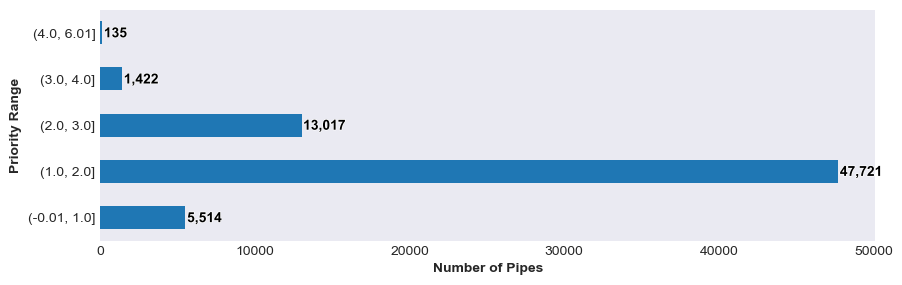

In [17]:
# %%

""" Assign Scores """
# Weightings
w1 = 1
w2 = 1
w3 = 1
w4 = 1
w5 = 1
w6 = 1

# Calculation
pipes['PRIORITY'] = w1 *pipes['HRAD_SCORE']/pipes['HRAD_SCORE'].max()
pipes['PRIORITY'] += w2 * pipes['LAND_SCORE']/pipes['LAND_SCORE'].max()
pipes['PRIORITY'] += w3 * pipes['ROAD_SCORE']/pipes['ROAD_SCORE'].max()
pipes['PRIORITY'] += w4 * pipes['ZONING_SCORE']/pipes['ZONING_SCORE'].max()
pipes['PRIORITY'] += w5 * pipes['AGE_SCORE']/pipes['AGE_SCORE'].max()
pipes['PRIORITY'] += w6 * pipes['ENVIRON_SCORE']/pipes['ENVIRON_SCORE'].max()

p_bins = pd.IntervalIndex.from_tuples([(-0.01,1), (1, 2), (2, 3), (3, 4), (4, 6.01)])
pipes['PCUT'] = pd.cut(pipes['PRIORITY'], p_bins)

plt.style.use('seaborn-v0_8-dark')
temp = pipes.groupby(['PCUT'])["GASSET"].count().reset_index()
temp.reset_index(inplace=True)
fig, ax = plt.subplots(figsize=(10,3))
temp.plot(ax=ax,x='PCUT', y='GASSET', kind='barh', legend=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

for index, row in temp.iterrows():
    ax.annotate(format(int(row['GASSET']), ","),
                xy=(row['GASSET']+100, row['index']-0.1),
                weight='bold',
                color='black',
                ha='left',
                path_effects=[pe.withStroke(linewidth=1, foreground="white")],
                size=10)

ax.set_xlabel("Number of Pipes", weight='bold')
ax.set_ylabel("Priority Range", weight='bold')
plt.show()

pipes['PCUT'] = pipes['PCUT'].astype(str)

In [18]:
# %%

""" Pipe Centroids """
cpipes = pipes[['GASSET', 'HRAD_SCORE', 'LAND_SCORE', 'ROAD_SCORE', 'ZONING_SCORE', 'AGE_SCORE', 'ENVIRON_SCORE', 'PRIORITY', 'geometry']].copy()

cpipes['LENGTH_M'] = cpipes.length
cpipes['LENGTH_M'] = cpipes['LENGTH_M'].round(2)

inspection_rate = 6.20
contingency = 1.1
cpipes['INSPECT_COST'] = cpipes['LENGTH_M'] * inspection_rate * contingency
cpipes['INSPECT_COST'] = cpipes['INSPECT_COST'].round(2)
cpipes['geometry'] = cpipes['geometry'].centroid
cpipes = cpipes.to_crs('EPSG:4326')

In [19]:
# %%

""" Cell Resolution """
res = 8
cells = cpipes.h3.geo_to_h3(res).reset_index()

if res < 10:
    col = f'h3_0{res}'
else:
    col = f'h3_{res}'

d1 = cells.groupby(col)['GASSET'].count().reset_index()
d1 = pd.merge(d1, cells.groupby(col)['PRIORITY'].sum().reset_index(), on=col)
d1 = pd.merge(d1, cells.groupby(col)['LENGTH_M'].sum().reset_index(), on=col)
d1 = pd.merge(d1, cells.groupby(col)['INSPECT_COST'].sum().reset_index(), on=col)

d1.set_index(col, inplace=True)
d1['LENGTH_KM'] = d1['LENGTH_M']/1000
d1['LENGTH_KM'] = d1['LENGTH_KM'].round(2)
d1['INSPECT_COST'] = d1['INSPECT_COST'].round(2)
d1['PRIORITY'] = d1['PRIORITY'].round(0)

cells = d1.h3.h3_to_geo_boundary()

p_bins = pd.IntervalIndex.from_tuples([(-0.01,100), (100, 500), (500, 1000), (1000, 2000), (2000, 10000)])
cells['CATEGORY'] = pd.cut(cells['PRIORITY'], p_bins)
cells['CATEGORY'] = cells['CATEGORY'].cat.rename_categories([5,4,3,2,1])
cells.sort_values(by='CATEGORY', ascending=True, inplace=True)
#cells.explore(column='CATEGORY', cmap='plasma', categorical=True)

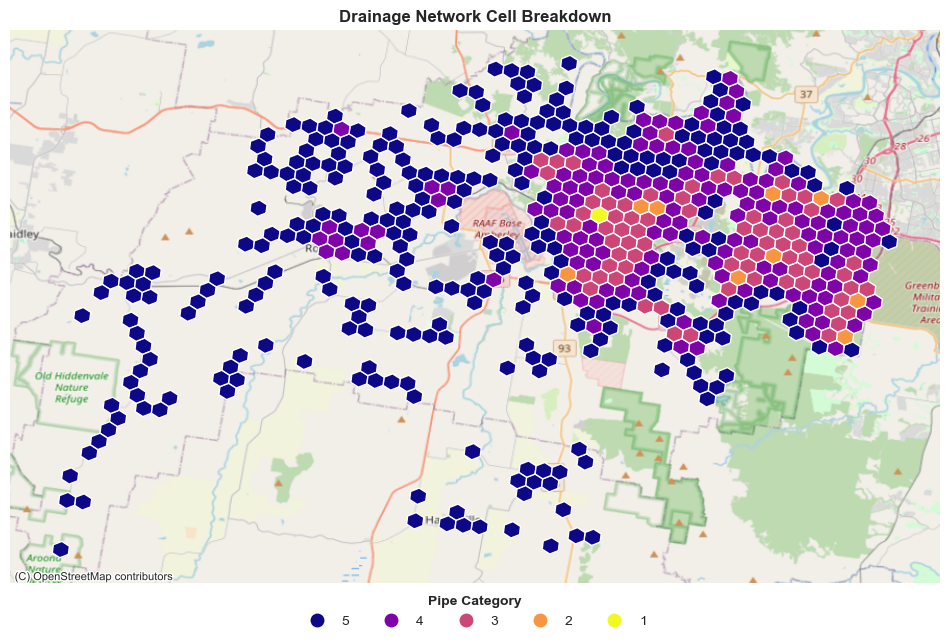

In [20]:
# %%

""" Visualise Cells """
fig, ax = plt.subplots(figsize=(12,12))
cells.plot(ax=ax, column='CATEGORY', 
           categorical=True, 
           cmap='plasma',
           edgecolor='white',
           legend=True, 
           legend_kwds={'bbox_to_anchor':(0.5,0),
                        'loc':'upper center',
                        'ncol':5,
                        'title':'Pipe Category',
                        'title_fontproperties':{'weight':'bold'}})
cnx.add_basemap(ax=ax, crs=cells.crs.to_string(), source=cnx.providers.OpenStreetMap.Mapnik)
ax.set_title('Drainage Network Cell Breakdown', weight='bold')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

In [21]:
# %%

""" Assign Back to Register """
# Need to Consider Decomissioned Pipes
cpipes = cpipes.h3.geo_to_h3(res).reset_index()
cells.rename(columns={'PRIORITY':'CELL_PRIORITY'}, inplace=True)
cells.reset_index(inplace=True)
cpipes = cpipes.merge(cells[[col,'CELL_PRIORITY']], on=col)
pipes = pipes.merge(cpipes[['GASSET', 'CELL_PRIORITY']])
pipes['CATEGORY'] = pd.cut(pipes['CELL_PRIORITY'], p_bins)
pipes['CATEGORY'] = pipes['CATEGORY'].cat.rename_categories([5,4,3,2,1])
#pipes.explore(column='CATEGORY', cmap='plasma', categorical=True)

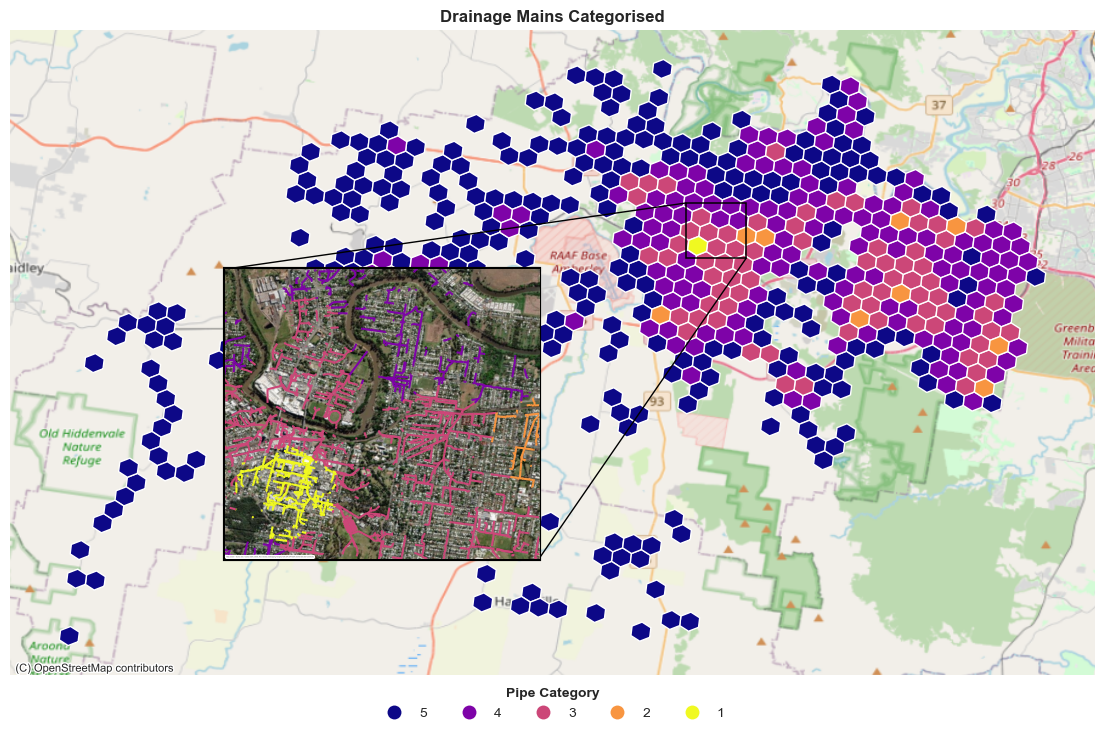

In [22]:
# %%

""" Visualise Grid With Individual Pipes """
fig, ax = plt.subplots(figsize=(14,14))
# Network Grid
cells.plot(ax=ax, column='CATEGORY', 
           categorical=True,
           cmap='plasma',
           edgecolor='white',
           legend=True, 
           legend_kwds={'bbox_to_anchor':(0.5,0),
                        'loc':'upper center',
                        'ncol':5,
                        'title':'Pipe Category',
                        'title_fontproperties':{'weight':'bold'}})
cnx.add_basemap(ax=ax, crs=cells.crs.to_string(), source=cnx.providers.OpenStreetMap.Mapnik)

# Inset of Asset Register
x1, y1, x2, y2 = 152.753376, -27.625341,  152.785824, -27.595474
inset = ax.inset_axes([152.503825, -27.794561, 0.17, 0.17],
                      transform=ax.transData,                       
                       xlim=(x1, x2), ylim=(y1, y2), 
                       xticklabels=[], yticklabels=[])
pipes.to_crs('EPSG:4326').cx[x1:x2, y1:y2].plot(ax=inset, column='CATEGORY', cmap='plasma', categorical=True)
cnx.add_basemap(ax=inset, crs=cells.crs.to_string(), 
            source=cnx.providers.Esri.WorldImagery, attribution_size=0)
inset.patch.set_edgecolor('black')  
inset.patch.set_linewidth(3)  

ax.indicate_inset_zoom(inset, edgecolor="black", alpha=1, linewidth=1.1)
ax.set_title('Drainage Mains Categorised', weight='bold')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

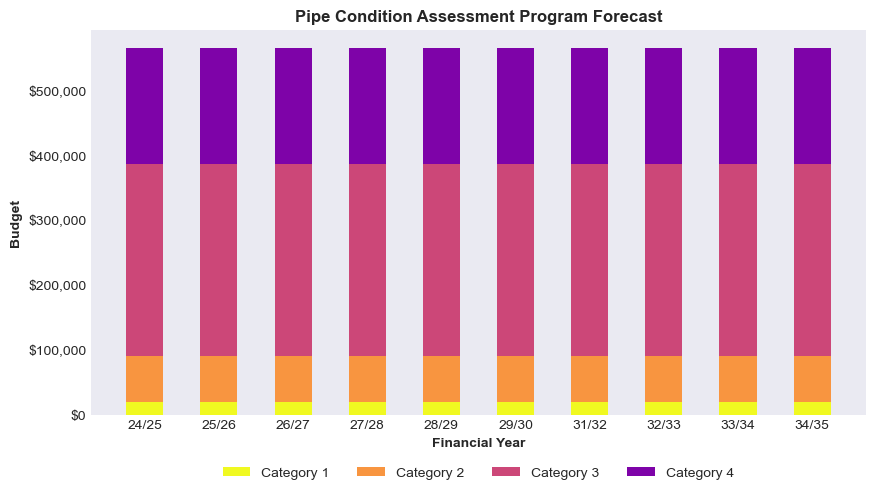

In [23]:
# %%

""" Budget Summary """
pipes['LENGTH_M'] = pipes.length
forecast = pd.read_excel(spatial_folder/'inspection_budget.xlsx')

fig, ax = plt.subplots(figsize=(10,5))

categories = {'Category 1':'#f0f921', 
              'Category 2':'#f89540', 
              'Category 3':'#cc4778', 
              'Category 4':'#7e03a8'}

width = 0.5 
bottom = np.zeros(len(forecast['Financial Year']))
for cat in categories:
    p = ax.bar(forecast['Financial Year'], forecast[cat], 
               label=cat, bottom=bottom, width=width, color = categories[cat])
    bottom += forecast[cat]

ax.legend(ncols=4, loc='lower center', bbox_to_anchor=(0.5, -0.2))
ax.set_title('Pipe Condition Assessment Program Forecast', weight='bold')
ax.set_xlabel('Financial Year', weight='bold')
ax.set_ylabel('Budget', weight='bold')

# Make commas for inspection cost
ylabels = []
for tick in list(ax.get_yticks()):
    ylabels.append('$' + format(int(tick), ","))

ax.set_yticklabels(ylabels)

plt.show()